# Part 1: Single-Label Classification

In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
train_data = pd.read_csv('./data/train_preprocess.csv')
val_data = pd.read_csv('./data/valid_preprocess.csv')
test_data = pd.read_csv('./data/test_preprocess.csv')

print('Train Data:', train_data.shape)
print('Validation Data:', val_data.shape)
print('Test Data:', test_data.shape)

Train Data: (810, 7)
Validation Data: (90, 7)
Test Data: (180, 7)


In [3]:
train_data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    return text

train_data['clean_text'] = train_data['sentence'].apply(clean_text)
val_data['clean_text'] = val_data['sentence'].apply(clean_text)
test_data['clean_text'] = test_data['sentence'].apply(clean_text)

In [5]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data['clean_text'])
X_val = vectorizer.transform(val_data['clean_text'])
X_test = vectorizer.transform(test_data['clean_text'])

# Target Labels
y_train = train_data['fuel']
y_val = val_data['fuel']
y_test = test_data['fuel']

param_grids = {
    'SVM': {
        'model': SVC(),
        'params': {
            'kernel': ['linear', 'rbf'],
            'C': [0.1, 1, 10]
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors':  [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    },
    'NB': {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.1, 0.5, 1.0]
        }
    }
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_models = {}
results = {}

for model_name, config in param_grids.items():
    print(f"Running GridSearchCV for {model_name}...")

    grid  = GridSearchCV(config['model'], config['params'], cv=kf, scoring='accuracy')

    grid.fit(X_train, y_train)

    best_models[model_name] = grid.best_estimator_
    results[model_name] = grid.best_score_

    print(f"Best Params for {model_name}: {grid.best_params_}")
    print(f"Best Cross-Validation Accuracy: {grid.best_score_:.4f}\n")

Running GridSearchCV for SVM...
Best Params for SVM: {'C': 10, 'kernel': 'linear'}
Best Cross-Validation Accuracy: 0.9654

Running GridSearchCV for KNN...
Best Params for KNN: {'n_neighbors': 7, 'weights': 'uniform'}
Best Cross-Validation Accuracy: 0.8852

Running GridSearchCV for NB...
Best Params for NB: {'alpha': 0.1}
Best Cross-Validation Accuracy: 0.8852



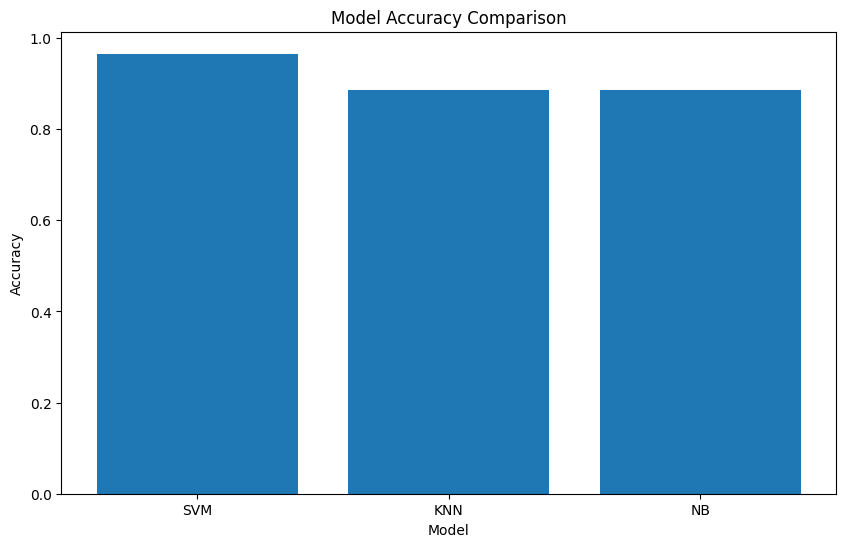

SVM Accuracy on Test Set: 0.9611
SVM Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.90      0.90        10
     neutral       0.98      0.99      0.98       149
    positive       0.85      0.81      0.83        21

    accuracy                           0.96       180
   macro avg       0.91      0.90      0.90       180
weighted avg       0.96      0.96      0.96       180



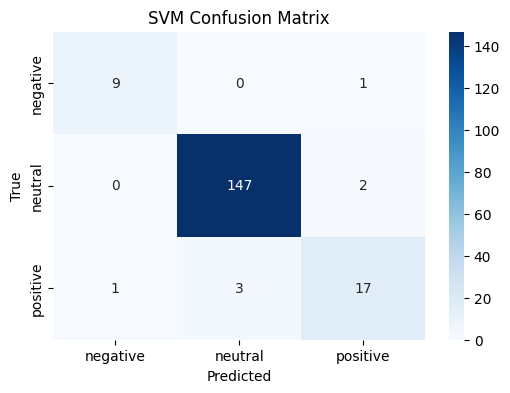

KNN Accuracy on Test Set: 0.9111
KNN Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.70      0.82        10
     neutral       0.92      0.99      0.95       149
    positive       0.75      0.43      0.55        21

    accuracy                           0.91       180
   macro avg       0.89      0.71      0.77       180
weighted avg       0.90      0.91      0.90       180



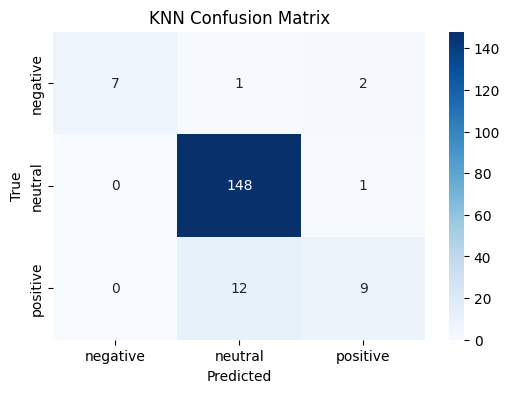

NB Accuracy on Test Set: 0.8889
NB Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.10      0.18        10
     neutral       0.92      0.99      0.95       149
    positive       0.61      0.52      0.56        21

    accuracy                           0.89       180
   macro avg       0.84      0.54      0.57       180
weighted avg       0.89      0.89      0.87       180



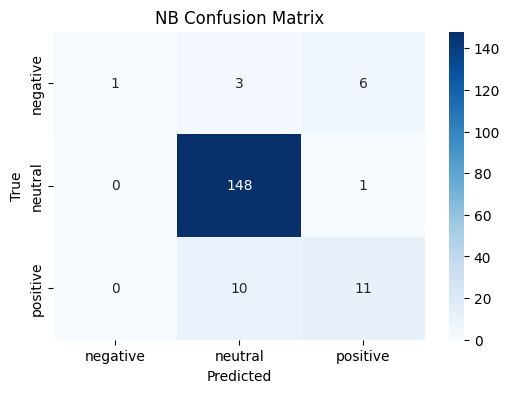

In [6]:
# plot every model accuracy
label = ['negative', 'neutral', 'positive']
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

for model_name, model in best_models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(f"{model_name} Accuracy on Test Set: {accuracy_score(y_test, y_pred):.4f}")
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,
                fmt='d', cmap='Blues', xticklabels=label, yticklabels=label)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [7]:
# Predict the test set
best_model = best_models['SVM']
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_data['predicted'] = y_pred
test_data

,sentence,fuel,machine,others,part,price,service,clean_text,predicted
0,Terios paling gagah . Apalagi warna merah meta...,neutral,neutral,positive,positive,neutral,neutral,terios paling gagah apalagi warna merah metalic,neutral
1,"gue pakai mobilio . menurut gue , bener fun to...",neutral,neutral,positive,neutral,neutral,neutral,gue pakai mobilio menurut gue bener fun to d...,neutral
2,ya walaupun memiliki desain sporty kalau tingk...,neutral,neutral,negative,positive,neutral,neutral,ya walaupun memiliki desain sporty kalau tingk...,neutral
3,Xpander laku keras di pasar Indonesia .,neutral,neutral,positive,neutral,neutral,neutral,xpander laku keras di pasar indonesia,neutral
4,"Kalau mau segala enak pakai Avanza saja , mas .",neutral,neutral,positive,neutral,neutral,neutral,kalau mau segala enak pakai avanza saja mas,neutral
...,...,...,...,...,...,...,...,...,...
175,"kecewa sama bengkel suzuki bendan, garapan eng...",neutral,neutral,neutral,neutral,neutral,negative,kecewa sama bengkel suzuki bendan garapan engg...,neutral
176,"Formo baris kedua, kursinya jelek banget.",neutral,neutral,neutral,negative,neutral,neutral,formo baris kedua kursinya jelek banget,neutral
177,Setahu saya Suzuki Splash tidak dilengkapi den...,neutral,neutral,neutral,negative,neutral,neutral,setahu saya suzuki splash tidak dilengkapi den...,neutral
178,kalo dari eksterior nya saya lebih suka brio d...,neutral,neutral,neutral,negative,neutral,neutral,kalo dari eksterior nya saya lebih suka brio d...,neutral


In [8]:
correct = test_data[test_data['fuel'] == test_data['predicted']]
incorrect = test_data[test_data['fuel'] != test_data['predicted']]
print(f"Correct Predictions: {len(correct)}")
print(f"Incorrect Predictions: {len(incorrect)}")

Correct Predictions: 173
Incorrect Predictions: 7


# Part 2: Multi-Label Classification

In [9]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import multilabel_confusion_matrix

In [10]:
labels = ['fuel', 'machine', 'others', 'part', 'price', 'service']

train_encoded = pd.get_dummies(train_data, columns=labels, dtype=int)
val_encoded = pd.get_dummies(val_data, columns=labels, dtype=int)
test_encoded = pd.get_dummies(test_data, columns=labels, dtype=int)

In [11]:
train_encoded.head()

,sentence,clean_text,fuel_negative,fuel_neutral,fuel_positive,machine_negative,machine_neutral,machine_positive,others_negative,others_neutral,others_positive,part_negative,part_neutral,part_positive,price_negative,price_neutral,price_positive,service_negative,service_neutral,service_positive
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,saya memakai honda jazz gk tahun pertama mel...,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0
1,Avanza kenapa jadi boros bensin begini dah ah....,avanza kenapa jadi boros bensin begini dah ah ...,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
2,"saran ku dan pengalaman ku , mending beli mobi...",saran ku dan pengalaman ku mending beli mobil...,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0
3,Dari segi harga juga pajero lebih mahal 30 jut...,dari segi harga juga pajero lebih mahal jutaa...,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0
4,Kalo menurut gw enak pajero si,kalo menurut gw enak pajero si,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0


In [12]:
label_columns = ['fuel_negative', 'fuel_neutral', 'fuel_positive', 'machine_negative', 'machine_neutral', 'machine_positive']

y_train_multi = train_encoded[label_columns]
y_val_multi = val_encoded[label_columns]
y_test_multi = test_encoded[label_columns]

SVM - Cross-Validation Accuracy: 0.7247 +/- 0.0252
SVM Final Accuracy: 0.75
SVM Classification Report
                  precision    recall  f1-score   support

   fuel_negative       1.00      0.00      0.00        10
    fuel_neutral       0.95      1.00      0.97       149
   fuel_positive       0.93      0.67      0.78        21
machine_negative       1.00      0.00      0.00        14
 machine_neutral       0.91      1.00      0.95       137
machine_positive       0.83      0.34      0.49        29

       micro avg       0.93      0.86      0.89       360
       macro avg       0.94      0.50      0.53       360
    weighted avg       0.93      0.86      0.85       360
     samples avg       0.93      0.86      0.88       360

SVM Confusion Matrix:


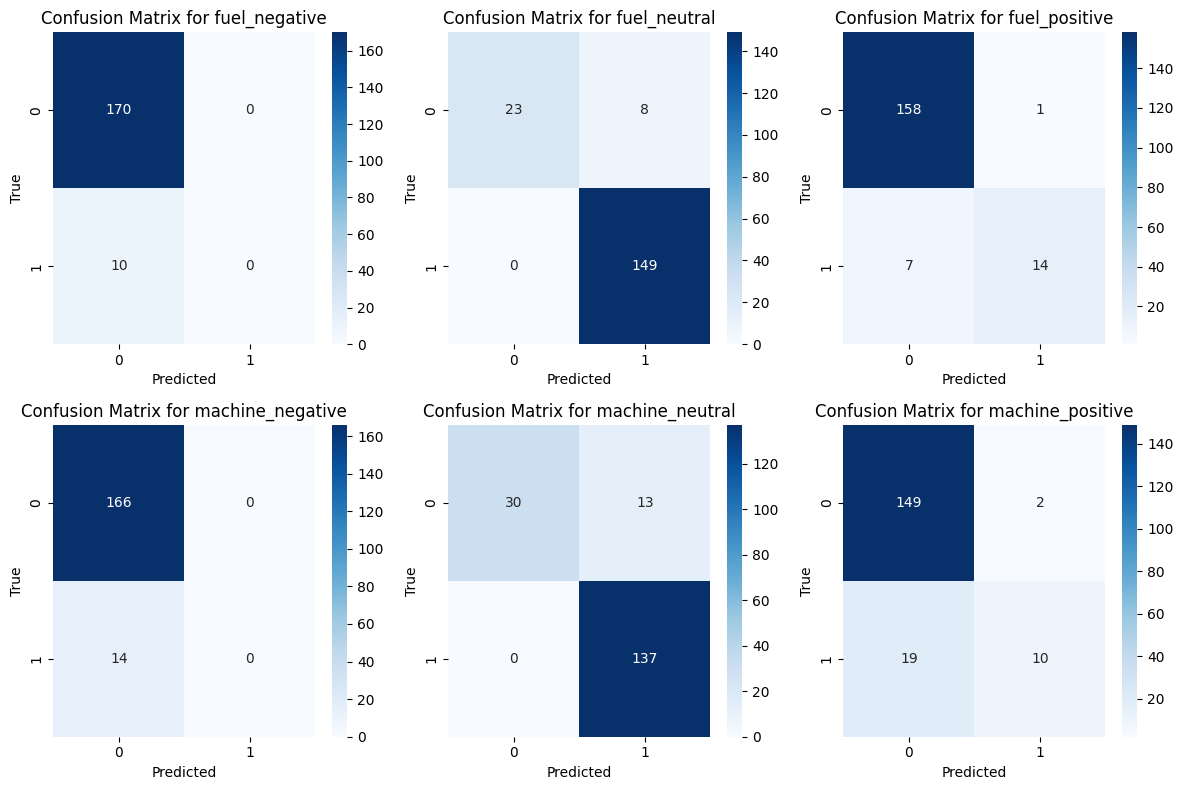

KNN - Cross-Validation Accuracy: 0.7346 +/- 0.0284
KNN Final Accuracy: 0.6555555555555556
KNN Classification Report
                  precision    recall  f1-score   support

   fuel_negative       1.00      0.30      0.46        10
    fuel_neutral       0.93      0.97      0.95       149
   fuel_positive       0.67      0.38      0.48        21
machine_negative       0.67      0.14      0.24        14
 machine_neutral       0.84      0.94      0.89       137
machine_positive       0.40      0.14      0.21        29

       micro avg       0.86      0.81      0.84       360
       macro avg       0.75      0.48      0.54       360
    weighted avg       0.83      0.81      0.80       360
     samples avg       0.86      0.81      0.83       360

KNN Confusion Matrix:


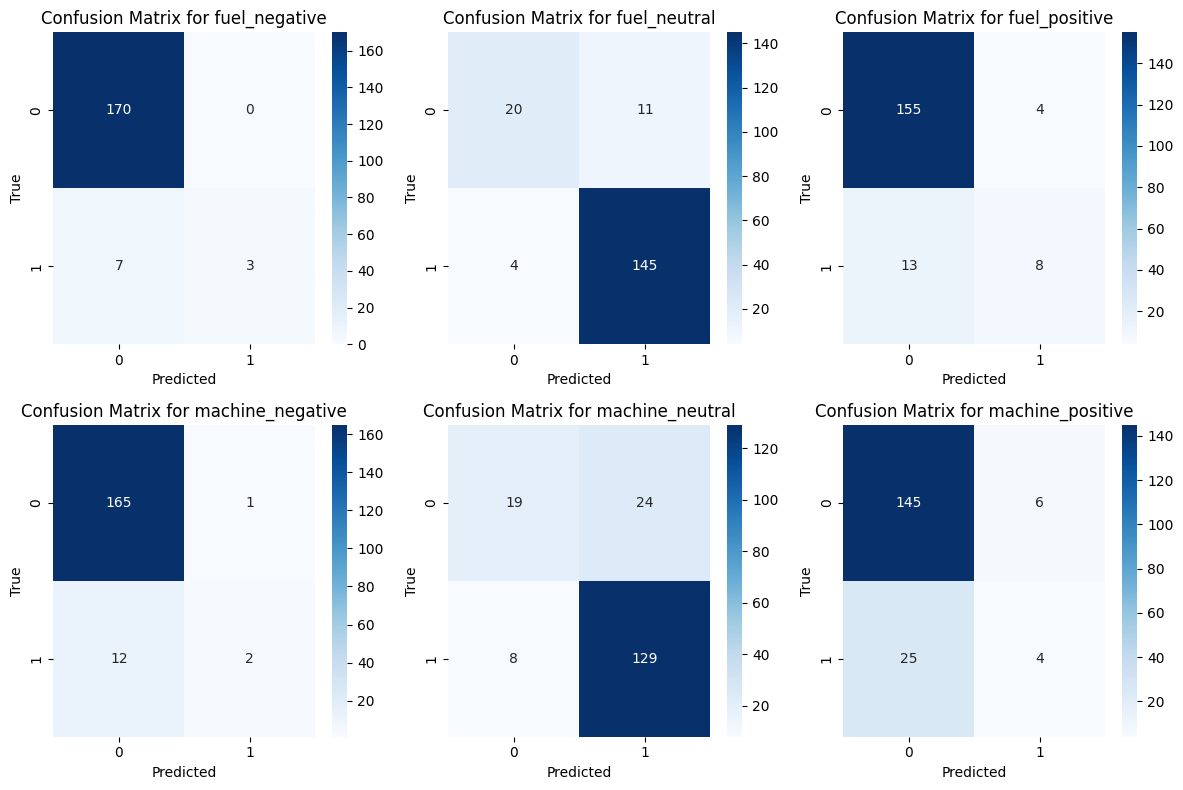

NB - Cross-Validation Accuracy: 0.6667 +/- 0.0237
NB Final Accuracy: 0.6388888888888888
NB Classification Report
                  precision    recall  f1-score   support

   fuel_negative       1.00      0.00      0.00        10
    fuel_neutral       0.84      1.00      0.91       149
   fuel_positive       1.00      0.00      0.00        21
machine_negative       1.00      0.00      0.00        14
 machine_neutral       0.77      1.00      0.87       137
machine_positive       1.00      0.03      0.07        29

       micro avg       0.81      0.80      0.80       360
       macro avg       0.94      0.34      0.31       360
    weighted avg       0.85      0.80      0.71       360
     samples avg       0.81      0.80      0.80       360

NB Confusion Matrix:


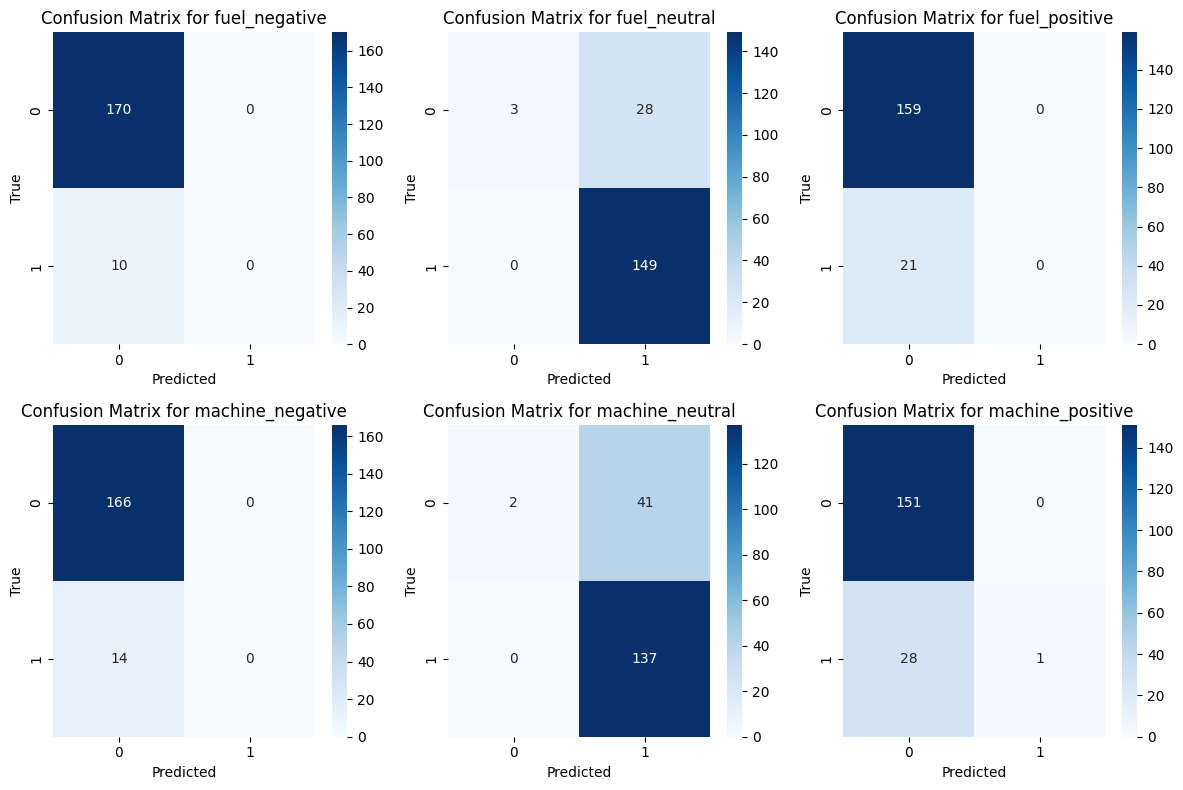

In [13]:
from sklearn.model_selection import KFold, cross_val_score
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.multiclass import OneVsOneClassifier
import numpy as np

multi_kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}

models = {"SVM": SVC(), "KNN": KNeighborsClassifier(), "NB": MultinomialNB()}

for model_name, model in models.items():
    wrapped_model = BinaryRelevance(model)

    scores = cross_val_score(
        wrapped_model, 
        X_train, 
        y_train_multi, 
        cv=multi_kf, 
        scoring='accuracy',
        n_jobs=1,
    )

    results[model_name] = scores
    print(
        f"{model_name} - Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}"
    )

    wrapped_model.fit(X_train, y_train_multi)

    y_pred_multi = wrapped_model.predict(X_test)

    accuracy = accuracy_score(y_test_multi, y_pred_multi)
    print(f"{model_name} Final Accuracy:", accuracy)

    print(f"{model_name} Classification Report")
    print(
        classification_report(
            y_test_multi, 
            y_pred_multi, 
            target_names=label_columns, 
            zero_division=1
        )
    )

    print(f"{model_name} Confusion Matrix:")
    mcm = multilabel_confusion_matrix(y_test_multi, y_pred_multi)
    rows, cols = 2, 3
    fig, axes = plt.subplots(
        rows, cols, figsize=(cols * 4, rows * 4)
    )
    axes = axes.flatten()

    for i, (ax, label) in enumerate(zip(axes, label_columns)):
        sns.heatmap(mcm[i], annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_title(f"Confusion Matrix for {label}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    for j in range(len(label_columns), rows * cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [14]:
from scipy.sparse import csr_matrix
y_pred_test = {}
for model_name, model in models.items():
    wrapped_model = BinaryRelevance(model)
    wrapped_model.fit(X_train, y_train_multi)
    y_pred_test[model_name] = wrapped_model.predict(X_test)

for model_name, y_pred in y_pred_test.items():
    print(f"\n{model_name} Predictions:\n")
    dense_array = y_pred.toarray()
    print(dense_array)


SVM Predictions:

[[0 1 0 0 1 0]
 [0 1 0 0 1 0]
 [0 1 0 0 1 0]
 ...
 [0 1 0 0 1 0]
 [0 1 0 0 1 0]
 [0 0 1 0 1 0]]

KNN Predictions:

[[0 1 0 0 1 0]
 [0 1 0 0 1 0]
 [0 1 0 0 1 0]
 ...
 [0 1 0 0 1 0]
 [0 1 0 1 0 0]
 [0 0 1 0 1 0]]

NB Predictions:

[[0 1 0 0 1 0]
 [0 1 0 0 1 0]
 [0 1 0 0 1 0]
 ...
 [0 1 0 0 1 0]
 [0 1 0 0 1 0]
 [0 0 0 0 1 0]]
